### RANDOM FOREST MODEL

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [10]:
def load_data(years = ['2013','2014','2015']):
    file_name_1 = 'elspot-prices_'
    file_name_2 = '_hourly_dkk.csv'
    data_folder = os.getcwd().replace('notebook','data\\')
    all_data=[]
    for year in years:
        file_name_tot = data_folder + file_name_1 + year + file_name_2
        all_data.append(pd.read_csv(file_name_tot,encoding = "ISO-8859-1",sep=';',decimal=','))
    df = pd.concat(all_data, ignore_index=True,sort= True)
    return df
    

In [13]:
df = load_data()
df.head()

,Bergen,DK1,DK2,EE,ELE,FI,FRE,Hours,Kr.sand,LT,...,Molde,Oslo,SE1,SE2,SE3,SE4,SYS,Tr.heim,Tromsø,datetime
0,246.01,104.66,104.66,232.14,232.14,231.54,NaN,00 - 01,246.01,182.16,...,231.54,246.01,231.54,231.54,231.54,231.54,231.62,231.54,231.54,01/01/2013
1,245.94,82.50,82.50,228.34,228.34,205.21,NaN,01 - 02,245.94,176.19,...,229.83,245.94,205.21,205.21,205.21,205.21,227.29,229.83,229.83,01/01/2013
2,243.11,63.41,63.41,182.31,182.31,182.31,NaN,02 - 03,243.11,178.51,...,229.53,243.11,182.31,182.31,182.31,182.31,215.73,229.53,229.53,01/01/2013
3,235.20,0.75,0.75,162.69,162.69,162.69,NaN,03 - 04,235.20,177.91,...,229.08,235.20,162.69,162.69,162.69,162.69,207.97,229.08,229.08,01/01/2013
4,227.81,14.99,14.99,166.87,166.87,166.87,NaN,04 - 05,227.81,173.51,...,228.48,227.81,166.87,166.87,166.87,166.87,201.11,228.48,228.48,01/01/2013


In [7]:
def generate_shifted_features(df,n_shift,colname):
    pd.options.mode.chained_assignment = None
    df = df[['datetime','Hours','Bergen']]
    for t in range(1,n_shift):
        df.loc[:,colname+'_'+str(t)] = df.Bergen.shift(t)
    return df

In [8]:
df_bergen = generate_shifted_features(df,12,'Bergen')
df_bergen.head()

,datetime,Hours,Bergen,Bergen_1,Bergen_2,Bergen_3,Bergen_4,Bergen_5,Bergen_6,Bergen_7,Bergen_8,Bergen_9,Bergen_10,Bergen_11
0,01/01/2013,00 - 01,246.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/01/2013,01 - 02,245.94,246.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/01/2013,02 - 03,243.11,245.94,246.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/01/2013,03 - 04,235.20,243.11,245.94,246.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/01/2013,04 - 05,227.81,235.20,243.11,245.94,246.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print(df_bergen.shape)
df_clean = df_bergen.dropna()
print(df_clean.shape)

(26283, 15)
(26232, 15)


In [13]:
test_size = 8000
train_size = df_clean.shape[0]-test_size

X_train = df_clean.drop(['Bergen','Hours','datetime'],axis=1).head(train_size)
y_train = df_clean['Bergen'].head(train_size)
X_test = df_clean.drop(['Bergen','Hours','datetime'],axis=1).tail(test_size)
y_test = df_clean['Bergen'].tail(test_size)

In [14]:
X_train.head()

,Bergen_1,Bergen_2,Bergen_3,Bergen_4,Bergen_5,Bergen_6,Bergen_7,Bergen_8,Bergen_9,Bergen_10,Bergen_11,Bergen_12
12,241.02,239.60,223.79,226.02,221.85,225.50,223.26,227.81,235.20,243.11,245.94,246.01
13,245.12,241.02,239.60,223.79,226.02,221.85,225.50,223.26,227.81,235.20,243.11,245.94
14,245.72,245.12,241.02,239.60,223.79,226.02,221.85,225.50,223.26,227.81,235.20,243.11
15,244.22,245.72,245.12,241.02,239.60,223.79,226.02,221.85,225.50,223.26,227.81,235.20
16,250.94,244.22,245.72,245.12,241.02,239.60,223.79,226.02,221.85,225.50,223.26,227.81


In [15]:
y_train.head()

12    245.12
13    245.72
14    244.22
15    250.94
16    260.78
Name: Bergen, dtype: float64

In [23]:
# Number of trees in random forest
n_estimators = [10,25,50]
# Number of features to consider at every split
max_features = ['auto','sqrt',None]
# Maximum number of levels in tree
max_depth = [3,6,9]
# Minimum number of samples required to split a node
min_samples_split = [2,4, 6,8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [24]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
cv = KFold(4)
scorer = make_scorer(mean_absolute_error)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid = param_grid, cv = cv, scoring = scorer, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 1080 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3233 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  8.0min finished


GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 25, 50], 'max_features': ['auto', 'sqrt', None], 'max_depth': [3, 6, 9], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error), verbose=2)

In [25]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
y_pred = rf_random.best_estimator_.predict(X_test)

print(mean_absolute_error(y_test,y_pred))

21.65680023526936


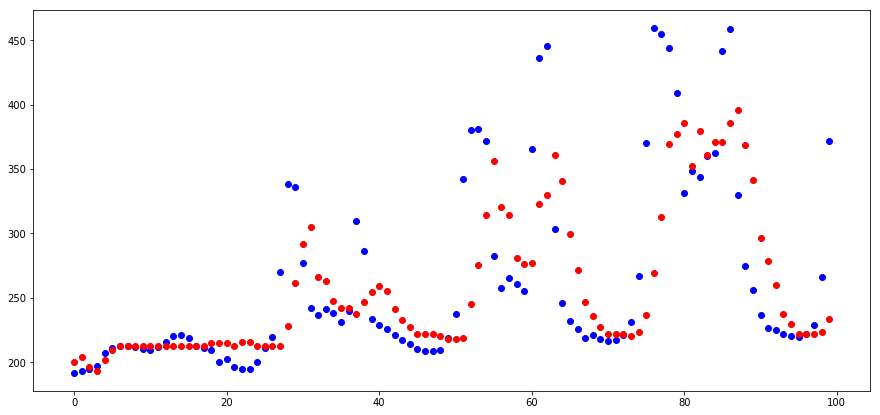

In [27]:
plot_samples = 100

plt.figure(figsize=(15,7))
plt.scatter(range(plot_samples),y_test[:plot_samples],color='b')
plt.scatter(range(plot_samples),y_pred[:plot_samples],color='r')
plt.show()